# TimesNet Training on ETT Datasets

This notebook trains TimesNet on all 4 ETT datasets (ETTh1, ETTh2, ETTm1, ETTm2) with different prediction horizons.

**Datasets:**
- ETTh1, ETTh2: Hourly data
- ETTm1, ETTm2: 15-minute data

**Configuration:**
- Input length: 96 (fixed, as in paper)
- Prediction horizons: {24, 48, 96, 192, 336, 720}
- Total experiments: 4 datasets × 6 horizons = 24 models

## Setup

In [1]:
!git clone https://github.com/ltruciosr-dev/timesnet-ett

# Change to the cloned repository directory
%cd timesnet-ett

Cloning into 'timesnet-ett'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 32 (delta 9), reused 27 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 2.94 MiB | 6.02 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/timesnet-ett


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Add src to path
sys.path.append('./src')

from src.train import TimesNetTrainer
from src.evaluate import (
    evaluate_and_save_results,
    plot_training_curves,
    visualize_horizon_predictions,
    plot_comprehensive_training_summary
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful")

✓ Imports successful


## Configuration

In [3]:
# Base paths
ROOT_PATH = './ETDataset/ETT-small/'
CHECKPOINT_BASE = './checkpoints'
RESULTS_DIR = './results'

# Create directories
os.makedirs(CHECKPOINT_BASE, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Datasets
DATASETS = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2']

# Fixed input length (as in paper)
SEQ_LEN = 96

# Prediction horizons
PRED_LENS = [24, 48, 96, 192, 336, 720]

# Model hyperparameters (from paper)
MODEL_CONFIGS = {
    'ETTh1': {'d_model': 16, 'd_ff': 32},
    'ETTh2': {'d_model': 16, 'd_ff': 32},
    'ETTm1': {'d_model': 32, 'd_ff': 64},
    'ETTm2': {'d_model': 32, 'd_ff': 64},
}

# Training config
TRAIN_CONFIG = {
    'enc_in': 7,
    'c_out': 7,
    'top_k': 5,
    'e_layers': 2,
    'num_kernels': 6,
    'dropout': 0.1,
    'embed': 'fixed',
    'batch_size': 32,
    'learning_rate': 0.0001,
    'train_epochs': 10,
    'patience': 3,
    'lradj': 'type1',
    'use_amp': False,
    'num_workers': 0,
}

print(f"✓ Configuration set")
print(f"  - Datasets: {DATASETS}")
print(f"  - Input length: {SEQ_LEN}")
print(f"  - Prediction horizons: {PRED_LENS}")
print(f"  - Total experiments: {len(DATASETS) * len(PRED_LENS)}")

✓ Configuration set
  - Datasets: ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2']
  - Input length: 96
  - Prediction horizons: [24, 48, 96, 192, 336, 720]
  - Total experiments: 24


## Training Function

In [4]:
def train_single_model(dataset_name, pred_len):
    """
    Train a single TimesNet model with comprehensive visualizations

    Args:
        dataset_name: Dataset name (e.g., 'ETTh1')
        pred_len: Prediction horizon

    Returns:
        dict: Training results
    """
    print("\n" + "="*70)
    print(f"Training: {dataset_name} | seq_len={SEQ_LEN} → pred_len={pred_len}")
    print("="*70)

    # Create config
    config = {
        'root_path': ROOT_PATH,
        'data_path': f'{dataset_name}.csv',
        'seq_len': SEQ_LEN,
        'pred_len': pred_len,
        'checkpoints': f'{CHECKPOINT_BASE}/{dataset_name}_{SEQ_LEN}_{pred_len}',
        **TRAIN_CONFIG,
        **MODEL_CONFIGS[dataset_name]
    }

    # Create checkpoint directory
    os.makedirs(config['checkpoints'], exist_ok=True)

    # Train
    trainer = TimesNetTrainer(config)
    train_losses, val_losses = trainer.train()

    # Test
    test_results = trainer.test()

    # ========== ENHANCED VISUALIZATIONS ==========

    print("\n📊 Creating visualizations...")

    # 1. Horizon predictions (input context + forecast)
    print("  → Horizon predictions (train/val/test samples)...")
    visualize_horizon_predictions(
        model=trainer.model,
        train_loader=trainer.train_loader,
        val_loader=trainer.val_loader,
        test_loader=trainer.test_loader,
        device=trainer.device,
        scaler=trainer.train_dataset.scaler,
        seq_len=config['seq_len'],
        pred_len=config['pred_len'],
        num_samples=3,
        feature_idx=0,
        feature_name='OT',
        save_path=f'{RESULTS_DIR}/{dataset_name}_{SEQ_LEN}_{pred_len}_horizons.png'
    )

    # 2. Comprehensive training summary (4-panel plot)
    print("  → Comprehensive training summary...")
    plot_comprehensive_training_summary(
        train_losses=train_losses,
        val_losses=val_losses,
        test_results=test_results,
        dataset_name=dataset_name,
        seq_len=config['seq_len'],
        pred_len=config['pred_len'],
        save_path=f'{RESULTS_DIR}/{dataset_name}_{SEQ_LEN}_{pred_len}_summary.png'
    )

    # 3. Evaluate on all splits
    print("  → Evaluating all splits (train/val/test)...")
    all_split_results = evaluate_and_save_results(
        model=trainer.model,
        train_loader=trainer.train_loader,
        val_loader=trainer.val_loader,
        test_loader=trainer.test_loader,
        device=trainer.device,
        scaler=trainer.train_dataset.scaler,
        save_path=f'{RESULTS_DIR}/{dataset_name}_{SEQ_LEN}_{pred_len}_all_metrics.txt'
    )

    # Prepare results
    results = {
        'dataset': dataset_name,
        'seq_len': SEQ_LEN,
        'pred_len': pred_len,
        'd_model': config['d_model'],
        'd_ff': config['d_ff'],
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_mse': test_results['mse'],
        'test_mae': test_results['mae'],
        'test_rmse': test_results['rmse'],
        'final_epoch': len(train_losses),
        # Add all split metrics
        'train_mse': all_split_results['train']['mse'],
        'train_mae': all_split_results['train']['mae'],
        'val_mse': all_split_results['val']['mse'],
        'val_mae': all_split_results['val']['mae'],
    }

    print(f"\n✓ Completed: {dataset_name}_{SEQ_LEN}_{pred_len}")
    print(f"  - Train MSE: {all_split_results['train']['mse']:.6f}")
    print(f"  - Val MSE:   {all_split_results['val']['mse']:.6f}")
    print(f"  - Test MSE:  {test_results['mse']:.6f}")
    print(f"  - Test MAE:  {test_results['mae']:.6f}")
    print(f"  - Test RMSE: {test_results['rmse']:.6f}")

    return results

## Train All Models

In [5]:
DATASETS = ['ETTh1'] # ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2']


######################################################################
# Experiment 1/6
######################################################################

Training: ETTh1 | seq_len=96 → pred_len=24
Using device: cuda
Initializing data loaders...
Train samples: 12075
Val samples: 1719
Test samples: 3461
Initializing model...
Model parameters: 598,431
Starting training...
	Iter: 100, Loss: 0.4223878
	Iter: 200, Loss: 0.3380650
	Iter: 300, Loss: 0.3420984
Epoch: 1 | Time: 24.60s
Train Loss: 0.4202700 | Val Loss: 0.3338290
Validation loss decreased (inf --> 0.333829). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.3864876
	Iter: 200, Loss: 0.2621755
	Iter: 300, Loss: 0.3211569
Epoch: 2 | Time: 22.30s
Train Loss: 0.3345500 | Val Loss: 0.3098838
Validation loss decreased (0.333829 --> 0.309884). Saving model ...
Updating learning rate to 5e-05
	Iter: 100, Loss: 0.2797817
	Iter: 200, Loss: 0.3293898
	Iter: 300, Loss: 0.3052159
Epoch: 3 | Time: 22.72s
Train Loss: 0

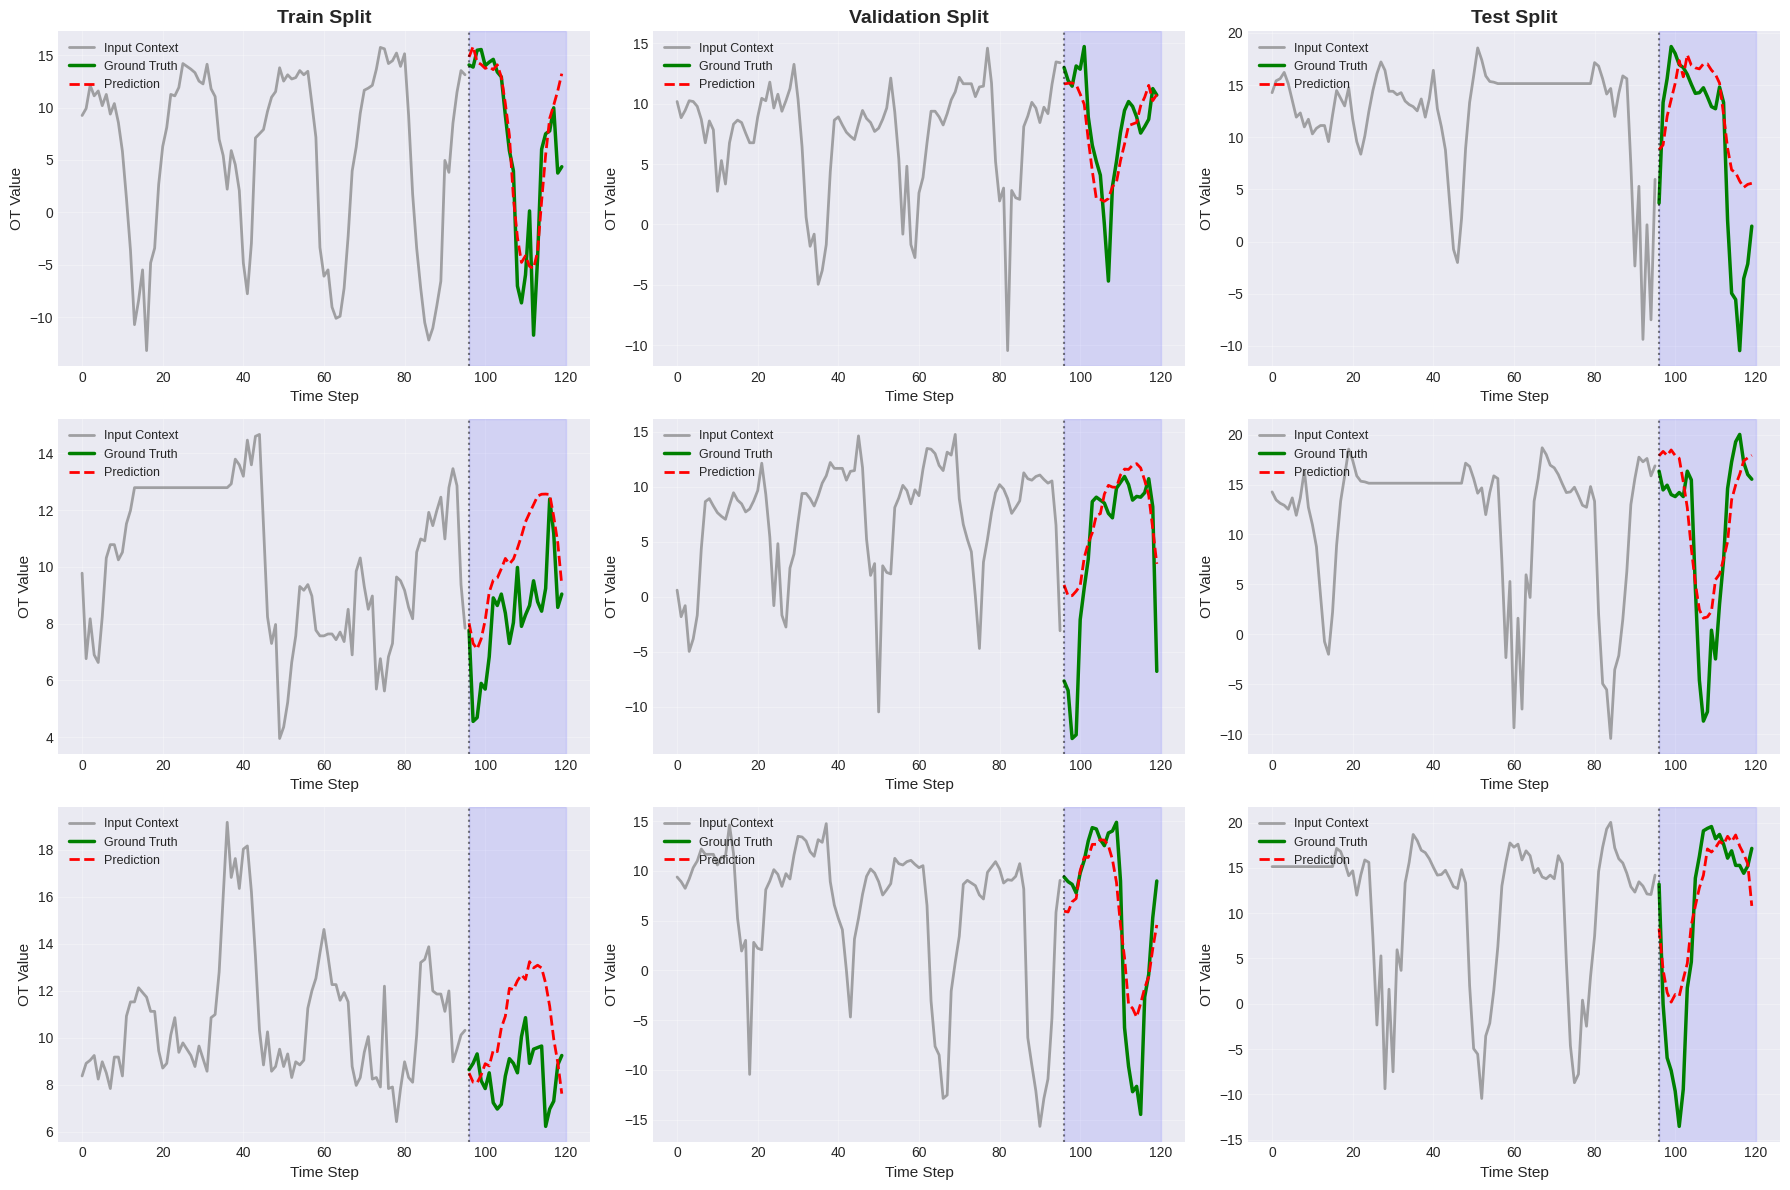

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTh1_96_24_summary.png


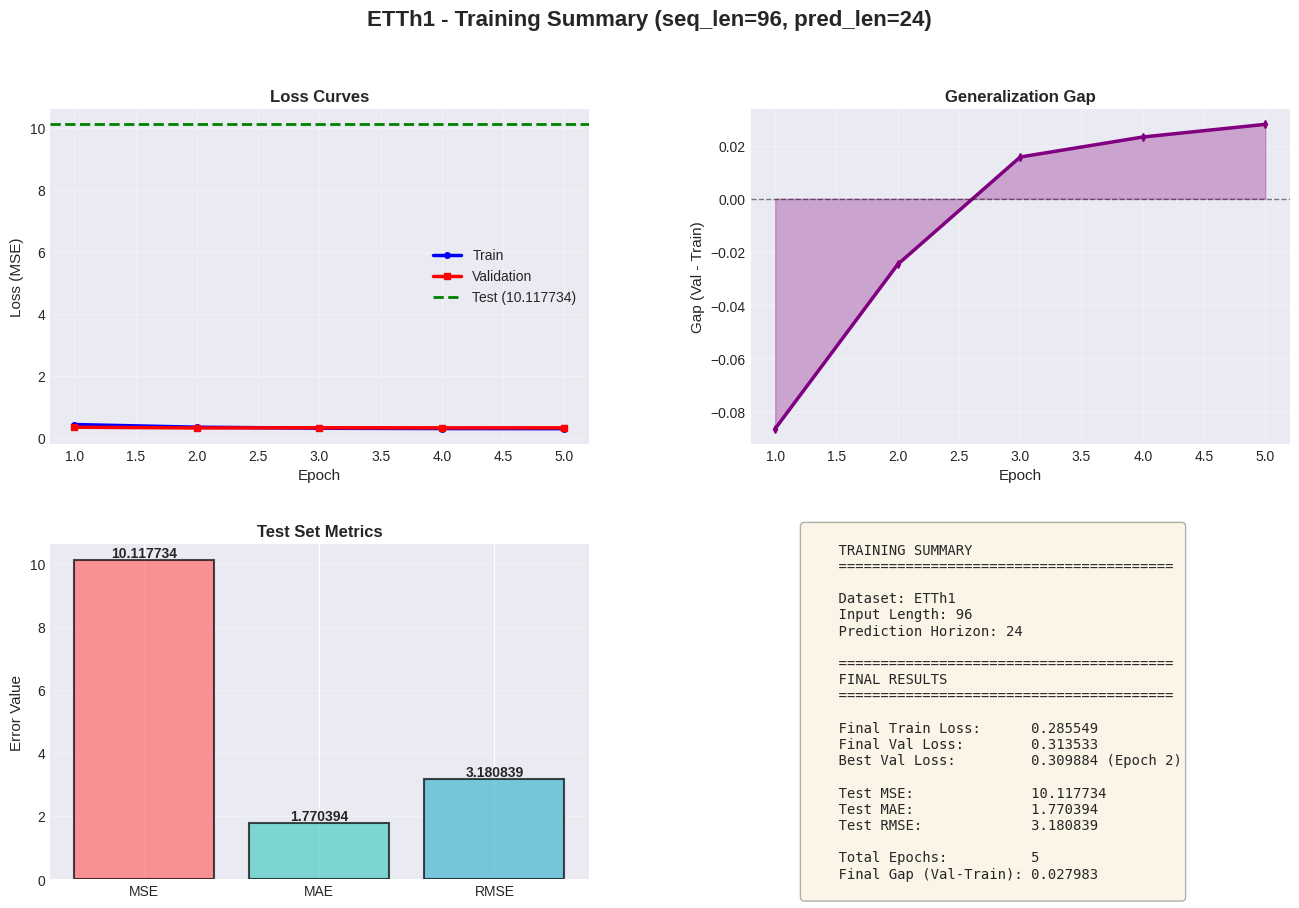

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 5.5391283
  MAE: 1.3983406
  RMSE: 2.3535352
  MAPE: 431287.6250000
  MSPE: 31456334184448.0000000

Validation Results:
  MSE: 6.9206719
  MAE: 1.4525182
  RMSE: 2.6307170
  MAPE: 42537.4023438
  MSPE: 3050397237248.0000000

Test Results:
  MSE: 10.1177340
  MAE: 1.7703944
  RMSE: 3.1808386
  MAPE: 69859.2031250
  MSPE: 3322079346688.0000000

❌ Error training ETTh1_96_24: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Experiment 2/6
######################################################################

Training: ETTh1 | seq_len=96 → pred_len=48
Using device: cuda
Initializing data loaders...
Train samples: 12051
Val samples: 1695
Test samples: 3437
Initializing model...
Model parameters: 600,759
Starting training...


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


	Iter: 100, Loss: 0.4861147
	Iter: 200, Loss: 0.3442764
	Iter: 300, Loss: 0.4169657
Epoch: 1 | Time: 28.44s
Train Loss: 0.4513670 | Val Loss: 0.3509642
Validation loss decreased (inf --> 0.350964). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.4018514
	Iter: 200, Loss: 0.3333478
	Iter: 300, Loss: 0.3002980
Epoch: 2 | Time: 28.32s
Train Loss: 0.3639627 | Val Loss: 0.3365279
Validation loss decreased (0.350964 --> 0.336528). Saving model ...
Updating learning rate to 5e-05
	Iter: 100, Loss: 0.4879631
	Iter: 200, Loss: 0.3243581
	Iter: 300, Loss: 0.3677431
Epoch: 3 | Time: 27.89s
Train Loss: 0.3301126 | Val Loss: 0.3348647
Validation loss decreased (0.336528 --> 0.334865). Saving model ...
Updating learning rate to 2.5e-05
	Iter: 100, Loss: 0.3152292
	Iter: 200, Loss: 0.3703046
	Iter: 300, Loss: 0.3264600
Epoch: 4 | Time: 27.83s
Train Loss: 0.3200983 | Val Loss: 0.3349144
EarlyStopping counter: 1 out of 3
Updating learning rate to 1.25e-05
	Iter: 100, Loss: 0.24205

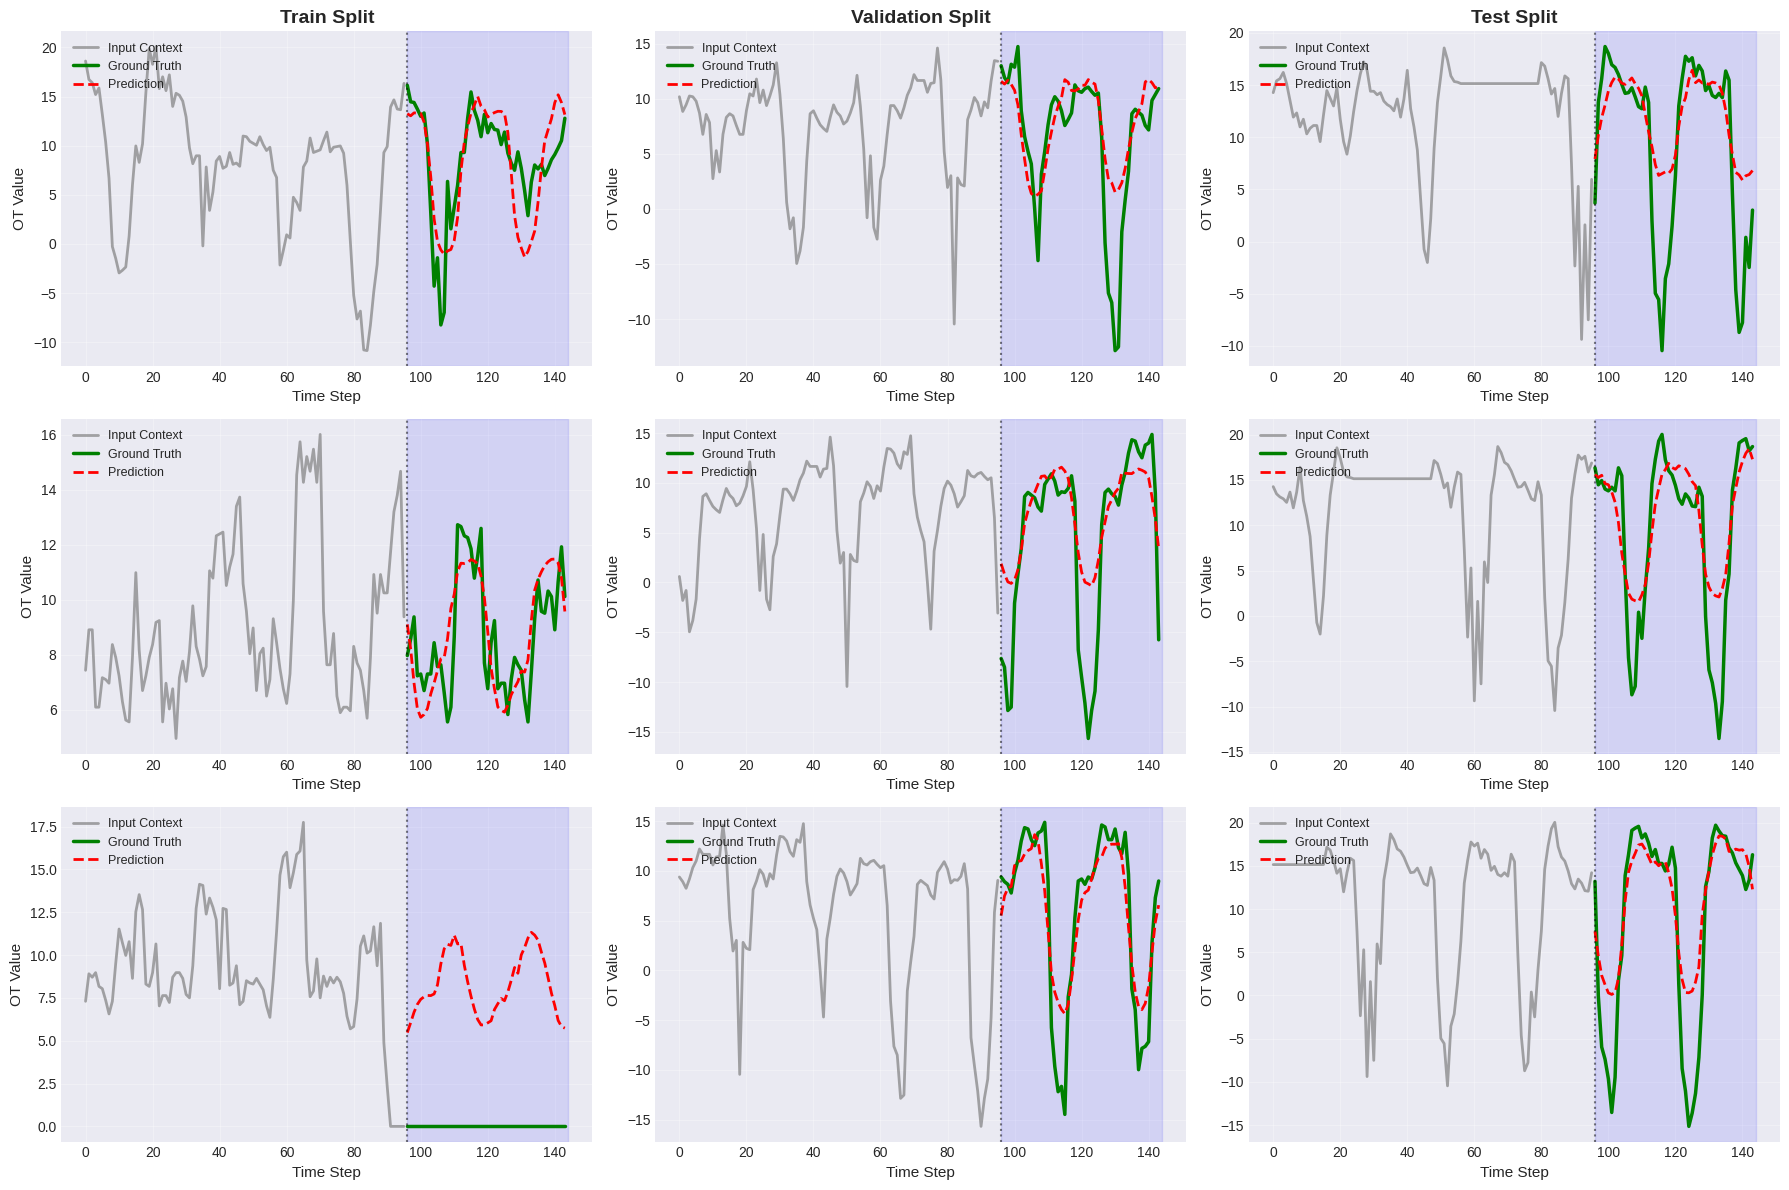

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTh1_96_48_summary.png


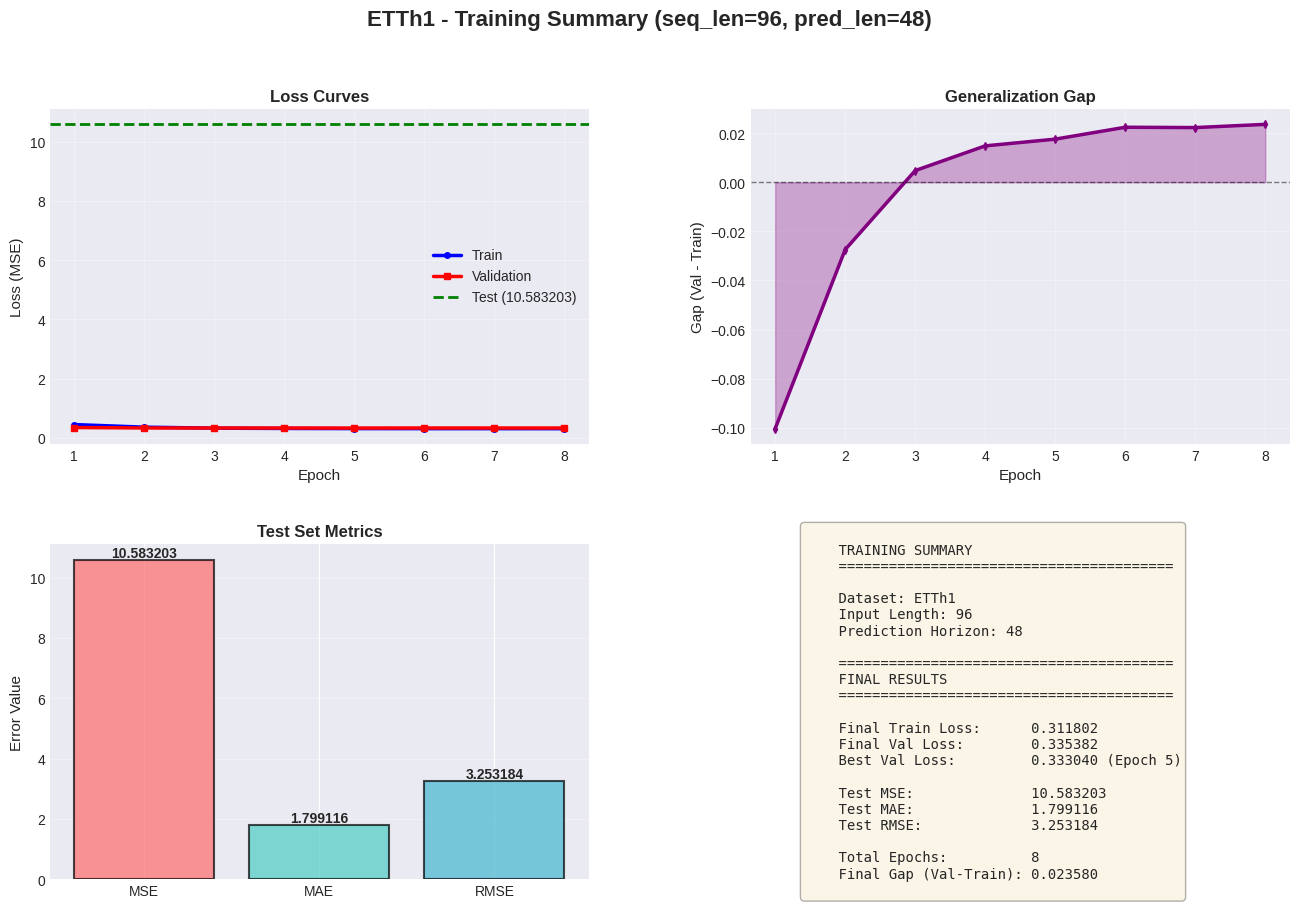

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 5.7062559
  MAE: 1.4142777
  RMSE: 2.3887770
  MAPE: 445672.4687500
  MSPE: 33618059591680.0000000

Validation Results:
  MSE: 7.7008052
  MAE: 1.5058956
  RMSE: 2.7750325
  MAPE: 45200.0351562
  MSPE: 3502769963008.0000000

Test Results:
  MSE: 10.5832033
  MAE: 1.7991160
  RMSE: 3.2531836
  MAPE: 66456.9296875
  MSPE: 2746724646912.0000000

❌ Error training ETTh1_96_48: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Experiment 3/6
######################################################################

Training: ETTh1 | seq_len=96 → pred_len=96
Using device: cuda
Initializing data loaders...
Train samples: 12003
Val samples: 1647
Test samples: 3389
Initializing model...
Model parameters: 605,415
Starting training...


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


	Iter: 100, Loss: 0.4056371
	Iter: 200, Loss: 0.6025347
	Iter: 300, Loss: 0.4619349
Epoch: 1 | Time: 36.49s
Train Loss: 0.5018125 | Val Loss: 0.3872701
Validation loss decreased (inf --> 0.387270). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.4243897
	Iter: 200, Loss: 0.3484934
	Iter: 300, Loss: 0.4218903
Epoch: 2 | Time: 36.42s
Train Loss: 0.4185241 | Val Loss: 0.3691865
Validation loss decreased (0.387270 --> 0.369187). Saving model ...
Updating learning rate to 5e-05
	Iter: 100, Loss: 0.3438773
	Iter: 200, Loss: 0.5666769
	Iter: 300, Loss: 0.3904740
Epoch: 3 | Time: 36.29s
Train Loss: 0.3945996 | Val Loss: 0.3704505
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
	Iter: 100, Loss: 0.3957946
	Iter: 200, Loss: 0.4295947
	Iter: 300, Loss: 0.3879179
Epoch: 4 | Time: 36.36s
Train Loss: 0.3857879 | Val Loss: 0.3670167
Validation loss decreased (0.369187 --> 0.367017). Saving model ...
Updating learning rate to 1.25e-05
	Iter: 100, Loss: 0.35461

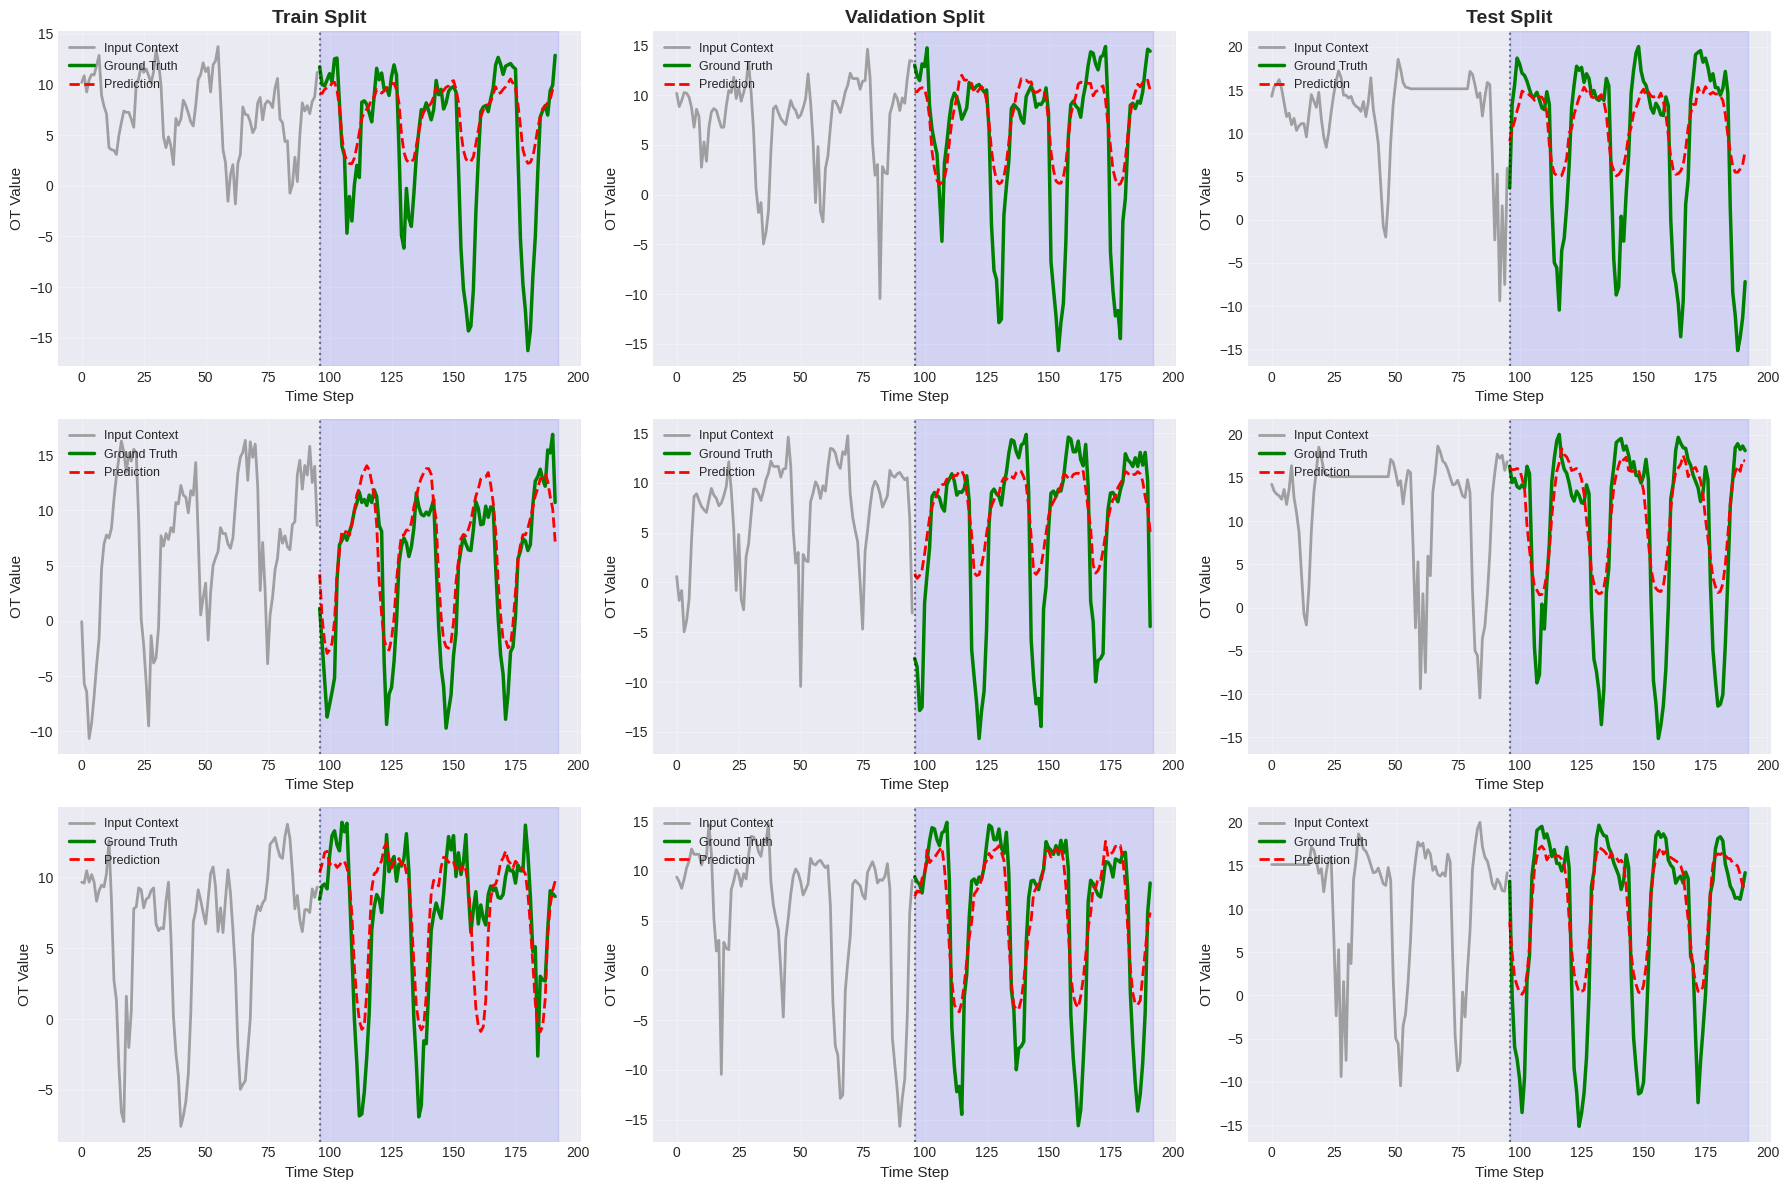

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTh1_96_96_summary.png


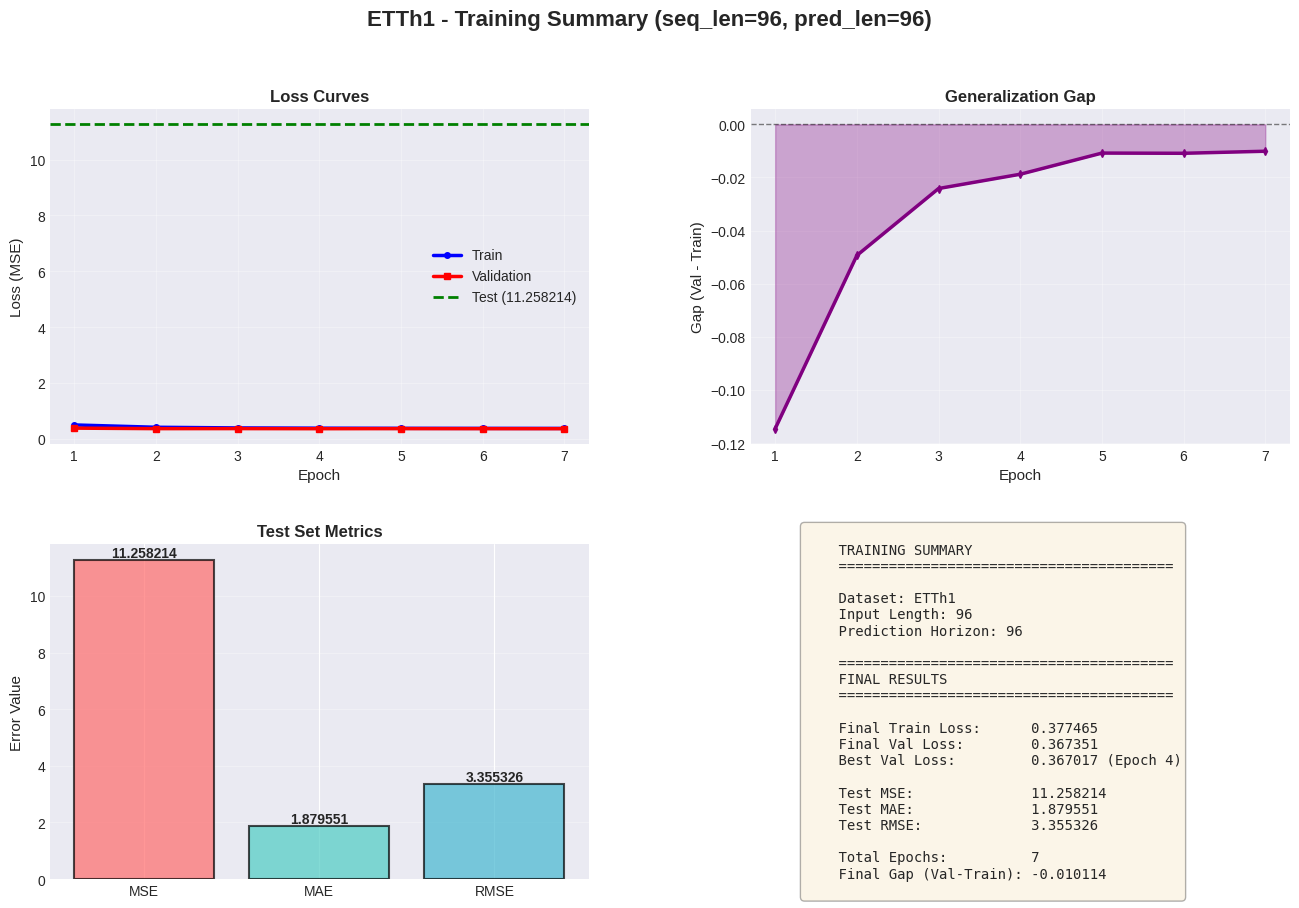

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 6.4696364
  MAE: 1.5198121
  RMSE: 2.5435481
  MAPE: 533338.0625000
  MSPE: 43794447728640.0000000

Validation Results:
  MSE: 8.8598633
  MAE: 1.5969262
  RMSE: 2.9765522
  MAPE: 50928.4414062
  MSPE: 3653771984896.0000000

Test Results:
  MSE: 11.2582140
  MAE: 1.8795511
  RMSE: 3.3553262
  MAPE: 76033.5234375
  MSPE: 3475478675456.0000000

❌ Error training ETTh1_96_96: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Experiment 4/6
######################################################################

Training: ETTh1 | seq_len=96 → pred_len=192
Using device: cuda
Initializing data loaders...


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


Train samples: 11907
Val samples: 1551
Test samples: 3293
Initializing model...
Model parameters: 614,727
Starting training...
	Iter: 100, Loss: 0.5039666
	Iter: 200, Loss: 0.5494827
	Iter: 300, Loss: 0.5888523
Epoch: 1 | Time: 46.22s
Train Loss: 0.5859503 | Val Loss: 0.4103643
Validation loss decreased (inf --> 0.410364). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.5438829
	Iter: 200, Loss: 0.5974364
	Iter: 300, Loss: 0.6144092
Epoch: 2 | Time: 45.35s
Train Loss: 0.5043958 | Val Loss: 0.4151342
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	Iter: 100, Loss: 0.3575840
	Iter: 200, Loss: 0.4817147
	Iter: 300, Loss: 0.4623498
Epoch: 3 | Time: 45.69s
Train Loss: 0.4759031 | Val Loss: 0.4112044
EarlyStopping counter: 2 out of 3
Updating learning rate to 2.5e-05
	Iter: 100, Loss: 0.4080955
	Iter: 200, Loss: 0.4945197
	Iter: 300, Loss: 0.4628693
Epoch: 4 | Time: 45.80s
Train Loss: 0.4659942 | Val Loss: 0.4075592
Validation loss decreased (0.410364

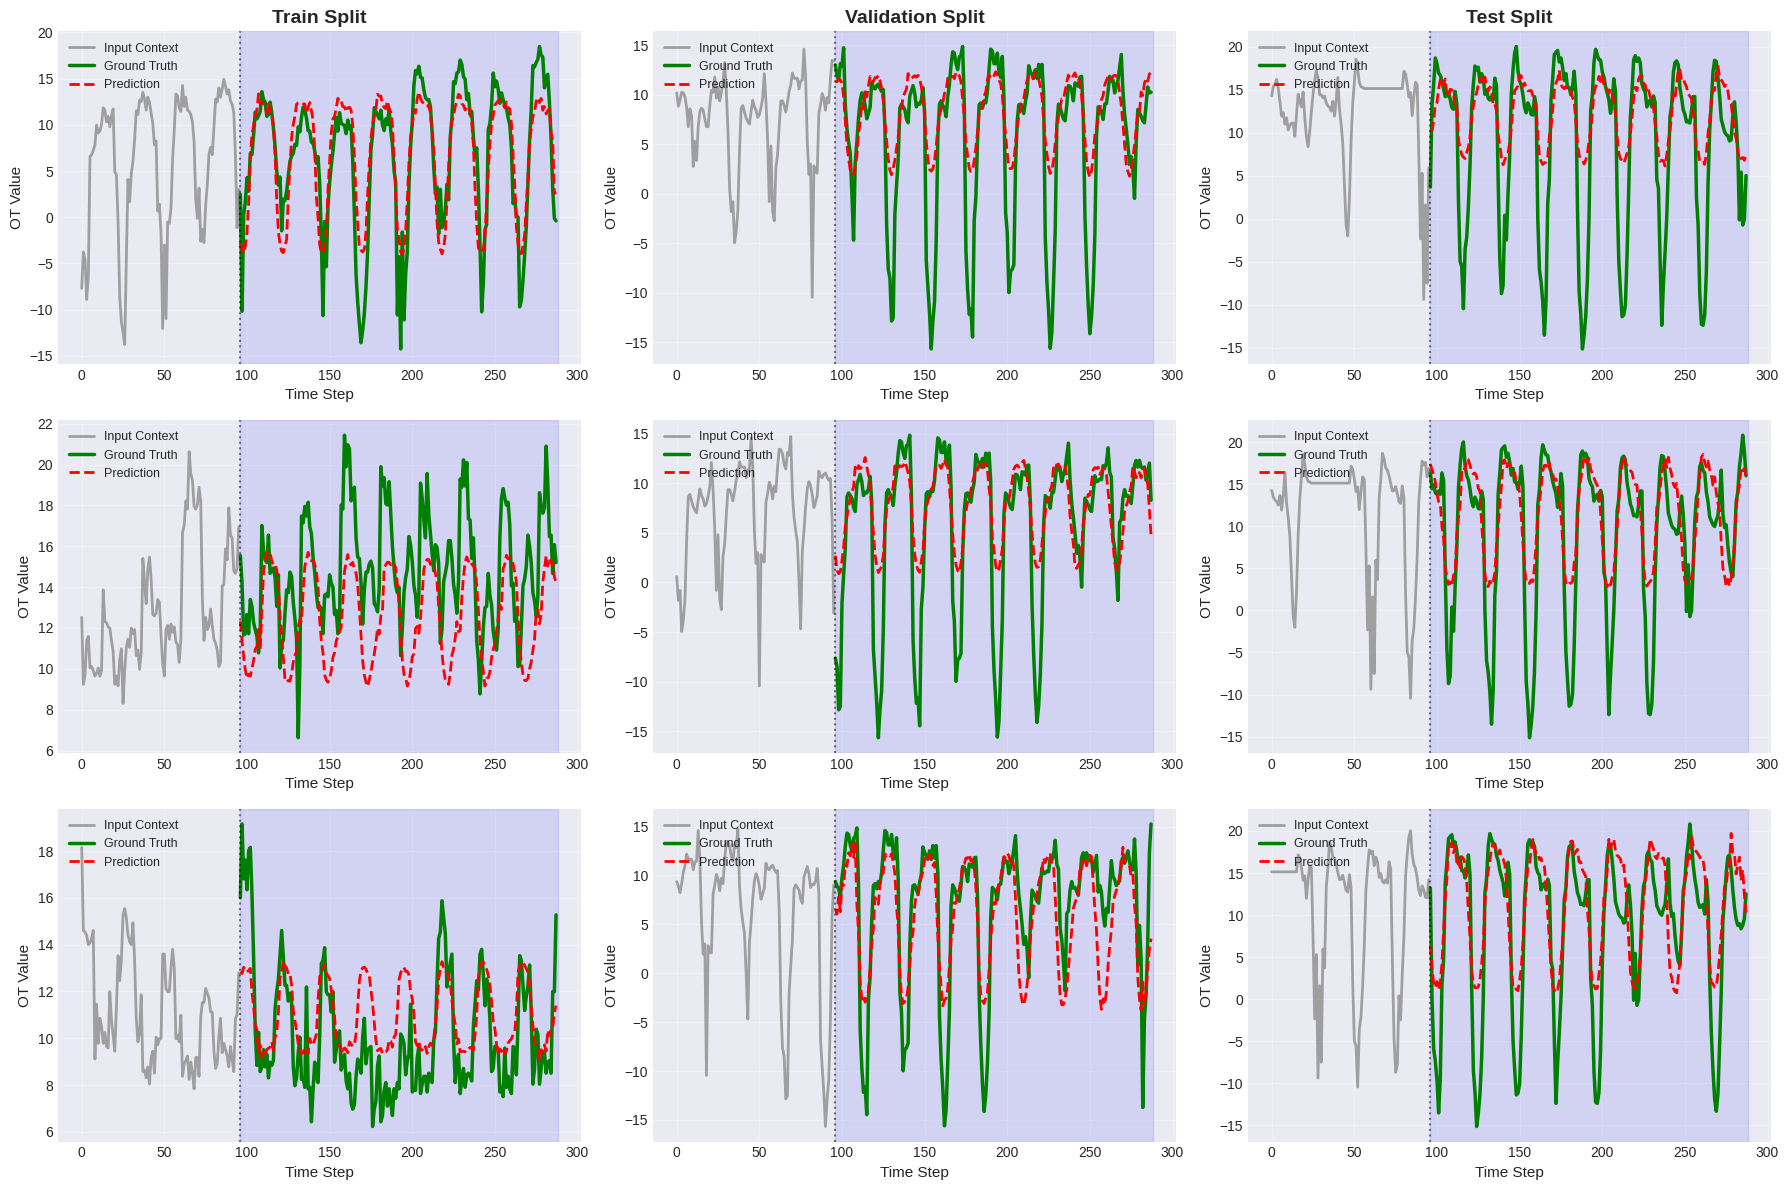

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTh1_96_192_summary.png


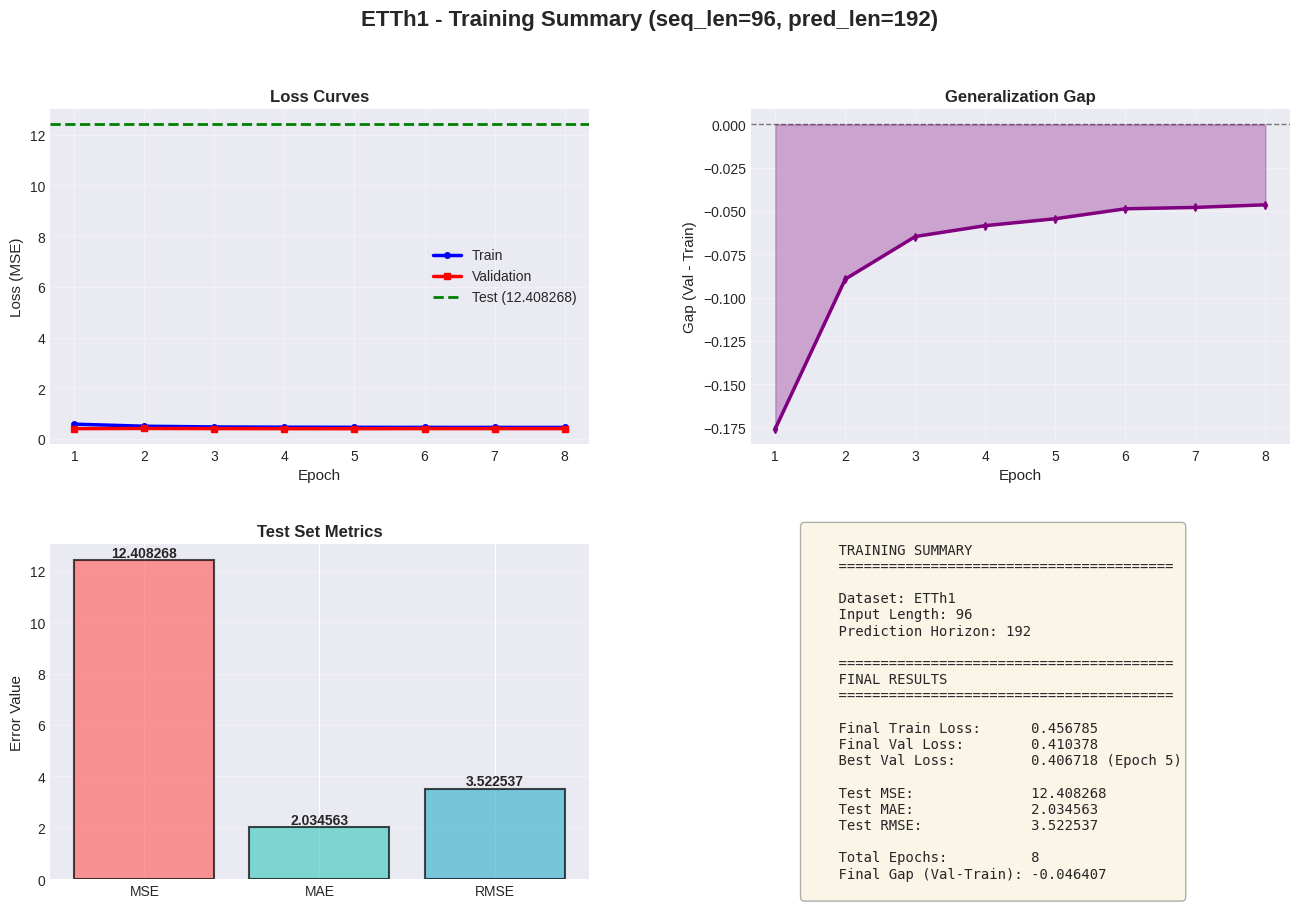

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 7.2287049
  MAE: 1.6263815
  RMSE: 2.6886251
  MAPE: 566805.8125000
  MSPE: 47825178066944.0000000

Validation Results:
  MSE: 10.3812675
  MAE: 1.7515508
  RMSE: 3.2219975
  MAPE: 62150.6132812
  MSPE: 4380866379776.0000000

Test Results:
  MSE: 12.4082680
  MAE: 2.0345631
  RMSE: 3.5225372
  MAPE: 81732.3671875
  MSPE: 3894694117376.0000000

❌ Error training ETTh1_96_192: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Experiment 5/6
######################################################################

Training: ETTh1 | seq_len=96 → pred_len=336
Using device: cuda
Initializing data loaders...


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


Train samples: 11763
Val samples: 1407
Test samples: 3149
Initializing model...
Model parameters: 628,695
Starting training...
	Iter: 100, Loss: 0.8193103
	Iter: 200, Loss: 0.5281639
	Iter: 300, Loss: 0.5774161
Epoch: 1 | Time: 64.39s
Train Loss: 0.6804081 | Val Loss: 0.4383243
Validation loss decreased (inf --> 0.438324). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.6182305
	Iter: 200, Loss: 0.6048309
	Iter: 300, Loss: 0.5207091
Epoch: 2 | Time: 62.84s
Train Loss: 0.5893765 | Val Loss: 0.4401865
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	Iter: 100, Loss: 0.6287667
	Iter: 200, Loss: 0.5104092
	Iter: 300, Loss: 0.6040409
Epoch: 3 | Time: 62.38s
Train Loss: 0.5754022 | Val Loss: 0.4354903
Validation loss decreased (0.438324 --> 0.435490). Saving model ...
Updating learning rate to 2.5e-05
	Iter: 100, Loss: 0.5431195
	Iter: 200, Loss: 0.4696146


KeyboardInterrupt: 

In [7]:
# Store all results
all_results = []

# Train all combinations
total_experiments = len(DATASETS) * len(PRED_LENS)
current_experiment = 0

for dataset_name in DATASETS:
    for pred_len in PRED_LENS:
        current_experiment += 1

        print(f"\n{'#'*70}")
        print(f"# Experiment {current_experiment}/{total_experiments}")
        print(f"{'#'*70}")

        try:
            results = train_single_model(dataset_name, pred_len)
            all_results.append(results)

        except Exception as e:
            print(f"\n❌ Error training {dataset_name}_{SEQ_LEN}_{pred_len}: {e}")
            import traceback
            traceback.print_exc()
            continue

print("\n" + "="*70)
print("✓ ALL TRAINING COMPLETED!")
print("="*70)

## Save Results

In [8]:
# Convert to DataFrame for easy analysis
results_df = pd.DataFrame([{
    'dataset': r['dataset'],
    'seq_len': r['seq_len'],
    'pred_len': r['pred_len'],
    'd_model': r['d_model'],
    'd_ff': r['d_ff'],
    'train_mse': r['train_mse'],
    'train_mae': r['train_mae'],
    'val_mse': r['val_mse'],
    'val_mae': r['val_mae'],
    'test_mse': r['test_mse'],
    'test_mae': r['test_mae'],
    'test_rmse': r['test_rmse'],
    'final_epoch': r['final_epoch']
} for r in all_results])

# Save to CSV
csv_path = f'{RESULTS_DIR}/all_results.csv'
results_df.to_csv(csv_path, index=False)
print(f"✓ Results saved to {csv_path}")

# Save detailed results (with training curves) to JSON
json_path = f'{RESULTS_DIR}/all_results_detailed.json'
with open(json_path, 'w') as f:
    json.dump(all_results, f, indent=2)
print(f"✓ Detailed results saved to {json_path}")

# Display summary
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
display(results_df)

✓ Results saved to ./results/all_results.csv
✓ Detailed results saved to ./results/all_results_detailed.json

RESULTS SUMMARY


""


## Results Analysis

### Results by Dataset

In [ ]:
# Group by dataset
for dataset in DATASETS:
    print(f"\n{'='*60}")
    print(f"{dataset} Results")
    print(f"{'='*60}")

    dataset_results = results_df[results_df['dataset'] == dataset]
    display(dataset_results[['pred_len', 'train_mse', 'val_mse', 'test_mse', 'test_mae', 'test_rmse', 'final_epoch']])

### Visualizations

In [ ]:
# Plot MSE vs Prediction Horizon for each dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, dataset in enumerate(DATASETS):
    ax = axes[idx]
    dataset_results = results_df[results_df['dataset'] == dataset].sort_values('pred_len')

    ax.plot(dataset_results['pred_len'], dataset_results['test_mse'],
            marker='o', linewidth=2, markersize=8, label='MSE')
    ax.plot(dataset_results['pred_len'], dataset_results['test_mae'],
            marker='s', linewidth=2, markersize=8, label='MAE')

    ax.set_xlabel('Prediction Horizon', fontsize=12)
    ax.set_ylabel('Error', fontsize=12)
    ax.set_title(f'{dataset} - Error vs Prediction Horizon', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/error_vs_horizon.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to {RESULTS_DIR}/error_vs_horizon.png")

In [ ]:
# Heatmap of MSE across datasets and horizons
pivot_mse = results_df.pivot(index='dataset', columns='pred_len', values='test_mse')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_mse, annot=True, fmt='.4f', cmap='YlOrRd',
            cbar_kws={'label': 'Test MSE'}, linewidths=0.5)
plt.title('Test MSE: Dataset vs Prediction Horizon', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('Dataset', fontsize=12)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/mse_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Heatmap saved to {RESULTS_DIR}/mse_heatmap.png")

In [ ]:
# Heatmap of MAE across datasets and horizons
pivot_mae = results_df.pivot(index='dataset', columns='pred_len', values='test_mae')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_mae, annot=True, fmt='.4f', cmap='YlGnBu',
            cbar_kws={'label': 'Test MAE'}, linewidths=0.5)
plt.title('Test MAE: Dataset vs Prediction Horizon', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('Dataset', fontsize=12)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/mae_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Heatmap saved to {RESULTS_DIR}/mae_heatmap.png")

### Statistical Summary

In [ ]:
# Summary statistics
print("="*70)
print("STATISTICAL SUMMARY")
print("="*70)

print("\nOverall Statistics:")
print(results_df[['test_mse', 'test_mae', 'test_rmse']].describe())

print("\nBest Results (by MSE):")
best_mse = results_df.loc[results_df.groupby('dataset')['test_mse'].idxmin()]
display(best_mse[['dataset', 'pred_len', 'test_mse', 'test_mae', 'test_rmse']])

print("\nBest Results (by MAE):")
best_mae = results_df.loc[results_df.groupby('dataset')['test_mae'].idxmin()]
display(best_mae[['dataset', 'pred_len', 'test_mse', 'test_mae', 'test_rmse']])

### Comparison with Paper Results

In [ ]:
# Paper results (from TimesNet paper Table 1)
paper_results = {
    'ETTh1': {
        96: {'mse': 0.384, 'mae': 0.402},
        192: {'mse': 0.436, 'mae': 0.429},
        336: {'mse': 0.491, 'mae': 0.469},
        720: {'mse': 0.521, 'mae': 0.491},
    },
    'ETTm1': {
        96: {'mse': 0.334, 'mae': 0.365},
        192: {'mse': 0.374, 'mae': 0.385},
        336: {'mse': 0.410, 'mae': 0.403},
        720: {'mse': 0.478, 'mae': 0.437},
    }
}

# Compare with our results
print("="*70)
print("COMPARISON WITH PAPER RESULTS")
print("="*70)

for dataset in ['ETTh1', 'ETTm1']:
    if dataset in paper_results:
        print(f"\n{dataset}:")
        print("-" * 60)
        print(f"{'Horizon':>10} {'Paper MSE':>12} {'Our MSE':>12} {'Diff':>10} {'Paper MAE':>12} {'Our MAE':>12} {'Diff':>10}")
        print("-" * 60)

        for horizon in [96, 192, 336, 720]:
            if horizon in paper_results[dataset]:
                paper = paper_results[dataset][horizon]
                our = results_df[(results_df['dataset'] == dataset) & (results_df['pred_len'] == horizon)]

                if not our.empty:
                    our_mse = our['test_mse'].values[0]
                    our_mae = our['test_mae'].values[0]

                    mse_diff = ((our_mse - paper['mse']) / paper['mse']) * 100
                    mae_diff = ((our_mae - paper['mae']) / paper['mae']) * 100

                    print(f"{horizon:>10} {paper['mse']:>12.4f} {our_mse:>12.4f} {mse_diff:>9.2f}% "
                          f"{paper['mae']:>12.4f} {our_mae:>12.4f} {mae_diff:>9.2f}%")

## Export Results Table (LaTeX)

In [ ]:
# Create LaTeX table
latex_table = []
latex_table.append("\\begin{table}[h]")
latex_table.append("\\centering")
latex_table.append("\\caption{TimesNet Results on ETT Datasets}")
latex_table.append("\\begin{tabular}{lcccc}")
latex_table.append("\\hline")
latex_table.append("Dataset & Horizon & MSE & MAE & RMSE \\\\")
latex_table.append("\\hline")

for dataset in DATASETS:
    dataset_results = results_df[results_df['dataset'] == dataset].sort_values('pred_len')
    for _, row in dataset_results.iterrows():
        latex_table.append(f"{row['dataset']} & {row['pred_len']} & "
                          f"{row['test_mse']:.4f} & {row['test_mae']:.4f} & {row['test_rmse']:.4f} \\\\")
    latex_table.append("\\hline")

latex_table.append("\\end{tabular}")
latex_table.append("\\end{table}")

latex_str = "\n".join(latex_table)

# Save to file
latex_path = f'{RESULTS_DIR}/results_table.tex'
with open(latex_path, 'w') as f:
    f.write(latex_str)

print(f"✓ LaTeX table saved to {latex_path}")
print("\nLaTeX Table:")
print(latex_str)

## Summary

✅ **Training Complete!**

**Trained Models:**
- 4 datasets (ETTh1, ETTh2, ETTm1, ETTm2)
- 6 prediction horizons each (24, 48, 96, 192, 336, 720)
- Total: 24 models

**Output Files:**

📊 **Results Data:**
- `results/all_results.csv` - Summary table with train/val/test metrics
- `results/all_results_detailed.json` - Detailed results with training curves

📈 **Visualizations per model (24 × 3 files = 72 plots):**
- `results/{dataset}_{seq_len}_{pred_len}_horizons.png` - Horizon predictions (train/val/test samples)
- `results/{dataset}_{seq_len}_{pred_len}_summary.png` - Comprehensive 4-panel training summary
- `results/{dataset}_{seq_len}_{pred_len}_all_metrics.txt` - All split metrics (train/val/test)

📊 **Aggregate Visualizations:**
- `results/error_vs_horizon.png` - Error vs horizon plots
- `results/mse_heatmap.png` - MSE heatmap
- `results/mae_heatmap.png` - MAE heatmap
- `results/results_table.tex` - LaTeX table

💾 **Model Checkpoints:**
- `checkpoints/{dataset}_{seq_len}_{pred_len}/checkpoint.pth` - Best model weights (24 models)